<a href="https://colab.research.google.com/github/jfonsecav/physics-tools/blob/main/EntregaDocumentada_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Construccion - exploracion de modelo predictivo basado en red neuronal temporal tipo FeedForward, que pronostica los precios de zanahoria en Corabastos.

### Proyecto final del curso Herramientas Computacionales
Presentado por : Fonseca Johann, Leon Daniel, Vallejo Cristhian




*Libreria de manejo de data: pandas
Librerias para la construccion de la red neuronal: Keras y Tensorflow*

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#CARGA  DEL DATASET
#Lectura Local: (Puede producir fallos la lectura del DATASET por versiones de pandas que no usan el parametro "squeeze"
#df = pd.read_csv('carrot.csv',  parse_dates=[0], header=None,index_col=0, squeeze=True,names=['fecha','unidades'])
#Lectura en Collab
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/carrot2.csv',  parse_dates=[0], header=None,index_col=0, squeeze=True,names=['fecha','unidades'])
df.head()

<ipython-input-3-281dc3f6938c>:5: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/carrot2.csv',  parse_dates=[0], header=None,index_col=0, squeeze=True,names=['fecha','unidades'])
<ipython-input-3-281dc3f6938c>:5: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/carrot2.csv',  parse_dates=[0], header=None,index_col=0, squeeze=True,names=['fecha','unidades'])


fecha
2021-01-01    1354.0
2021-02-01    1354.0
2021-03-01    1354.0
2021-04-01    1438.0
2021-05-01    1438.0
Name: unidades, dtype: float64

Dato inicial y final del dataset

In [ ]:
print(df.index.min())
print(df.index.max())
Ntotal = (len(df))    #Numero total de datos

2021-01-01 00:00:00
2023-12-11 00:00:00


*El dataset contiene el valor mayorista diario por kilo de zanahoria desde el 1 de enero de 2021 hasta el 11 de noviembre de 2023.*


Cantidad de muestras por periodo de tiempo, en este caso queremos ver las muestras anuales:

In [ ]:
print(len(df['2021']))
print(len(df['2022']))
print(len(df['2023']))

365
365
333


Algunos datos estadisticos de interes:

In [ ]:
df.describe()

count    1063.000000
mean     1943.991063
std       478.970690
min      1000.000000
25%      1635.250000
50%      1924.000000
75%      2208.000000
max      4042.000000
Name: unidades, dtype: float64

Observamos que para este producto (Zanahoria), la media del precio se encuentra en $ 1943 \$ $ con una desviacion estandar de $ 478.9\$$, situando el rango de precio en $(1465 - 2421)\$ $

Promedios mensuales

In [ ]:
meses =df.resample('M').mean()
meses
meses =df.resample('M').mean()

Numero de ventas por mes

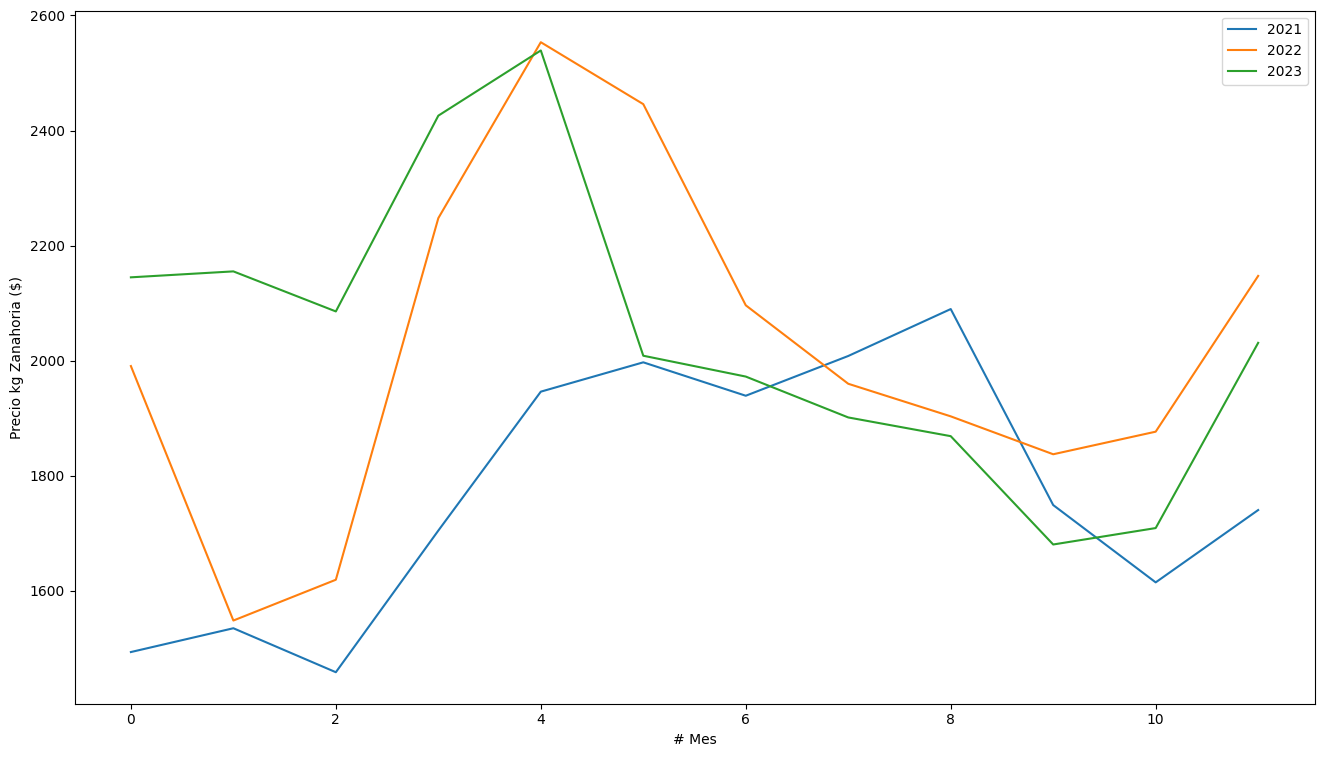

In [ ]:
plt.xlabel("# Mes")
plt.ylabel("Precio kg Zanahoria ($)")
plt.plot(meses['2021'].values,label='2021')
plt.plot(meses['2022'].values,label='2022')
plt.plot(meses['2023'].values, label='2023')
plt.legend()
plt.show()

Gráfica de ventas diarias (representacion anual)


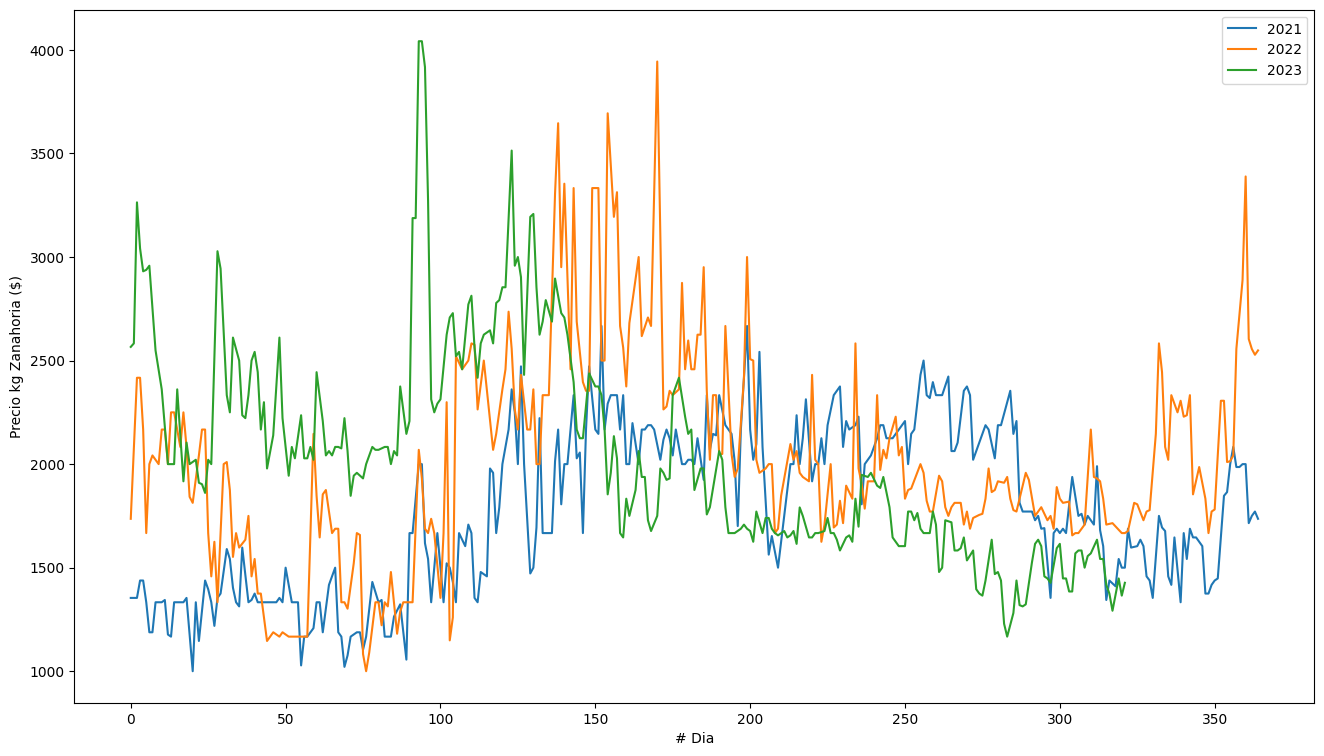

In [ ]:
plt.xlabel("# Dia")
plt.ylabel("Precio kg Zanahoria ($)")
y2021 = df['2021-01-01':'2021-12-31']
plt.plot(y2021.values,label='2021')
y2022 = df['2022-01-01':'2022-12-31']
plt.plot(y2022.values,label='2022')
y2023 = df['2023-01-01':'2023-11-29']
plt.plot(y2023.values,label='2023')
plt.legend()
plt.show()

Esta red la trataremos como un problema de tipo supervisado, entranada con backpropagation.

La funcion de activacion usada es $tanh$, normalizaremos los datos dentro del intervalo de (-1, 1) utilizando la funcion MinMaxScaler, para favorecer los calculos.

El optimizador usado es 'Adam'
y la metrica de 'perdida' (loss) sera mse = Mean Absolute Error

Entregamos los datos organizados como entradas y salidas.

En este codigo, las entradas seran un conjunto de datos (bloques de siete dias) anteriores al intervalo de prediccion, y la salida sera el valor predictivo de un octavo dia.

## **Preprocesado de Datos**

In [ ]:
PASOS=7

# Se convierten las series en aprendizaje supervisado
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input  (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Unificamos los valores
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Eliminar filas con valores NaN
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Carga del dataset
values = df.values
# Transformamos todos los datos a tipo float, para evitar errores
values = values.astype('float32')
# Normalizamos los valores en el rango -1,1
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # Redimensionamos a 1D los datos
scaled = scaler.fit_transform(values)
# Frame como aprendizaje supervisado
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,-0.767258,-0.767258,-0.767258,-0.712032,-0.712032,-0.781065,-0.876397,-0.876397
8,-0.767258,-0.767258,-0.712032,-0.712032,-0.781065,-0.876397,-0.876397,-0.781065
9,-0.767258,-0.712032,-0.712032,-0.781065,-0.876397,-0.876397,-0.781065,-0.781065
10,-0.712032,-0.712032,-0.781065,-0.876397,-0.876397,-0.781065,-0.781065,-0.781065
11,-0.712032,-0.781065,-0.876397,-0.876397,-0.781065,-0.781065,-0.781065,-0.773833


Obtenemos esta tabla, donde los valore var1(t-7) - var1(t-1) son los datos de entrada normalizados y var1(t)


In [ ]:
# Division de datos para el train y el test, la proporcion elegida fue 80% de los datos para el train y 20% para el test
values = reframed.values
Ntest = int(Ntotal*0.2)
print('Datos totales:',Ntotal)
print('Datos para test:',Ntest)
n_train_days = Ntotal - (Ntest+PASOS)
print('Datos para train:',n_train_days)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# Dividimos lo que seran entradas y salidas
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# Modificamos en la tamañor tal que muestre: [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

values = reframed.values



Datos totales: 1063
Datos para test: 212
Datos para train: 844
(844, 1, 7) (844,) (212, 1, 7) (212,)


In [ ]:
def crear_modeloFF():
    model = Sequential()
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model


## **ENTRENAMIENTO DE LA RED**

40 EPOCAS


In [ ]:
EPOCHS=50

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1, 7)              56        
                                                                 
 flatten (Flatten)           (None, 7)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 8         
                                                                 
Total params: 64 (256.00 Byte)
Trainable params: 64 (256.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
121/121 [==============================] - 3s 8ms/step - loss: 0.1433 - mse: 0.0375 - val_loss: 0.0805 - val_mse: 0.0140
Epoch 2/50
121/121 [==============================] - 1s 6ms/step - loss: 0.1299 - mse: 0.0323 - val_loss: 0.0743 - val_mse: 0.0120
Epoch 3/50
121/121 [

Visualizamos al conjunto de validación del DATASET usado en el entrenamiento del modelo ()

7/7 [==============================] - 0s 3ms/step


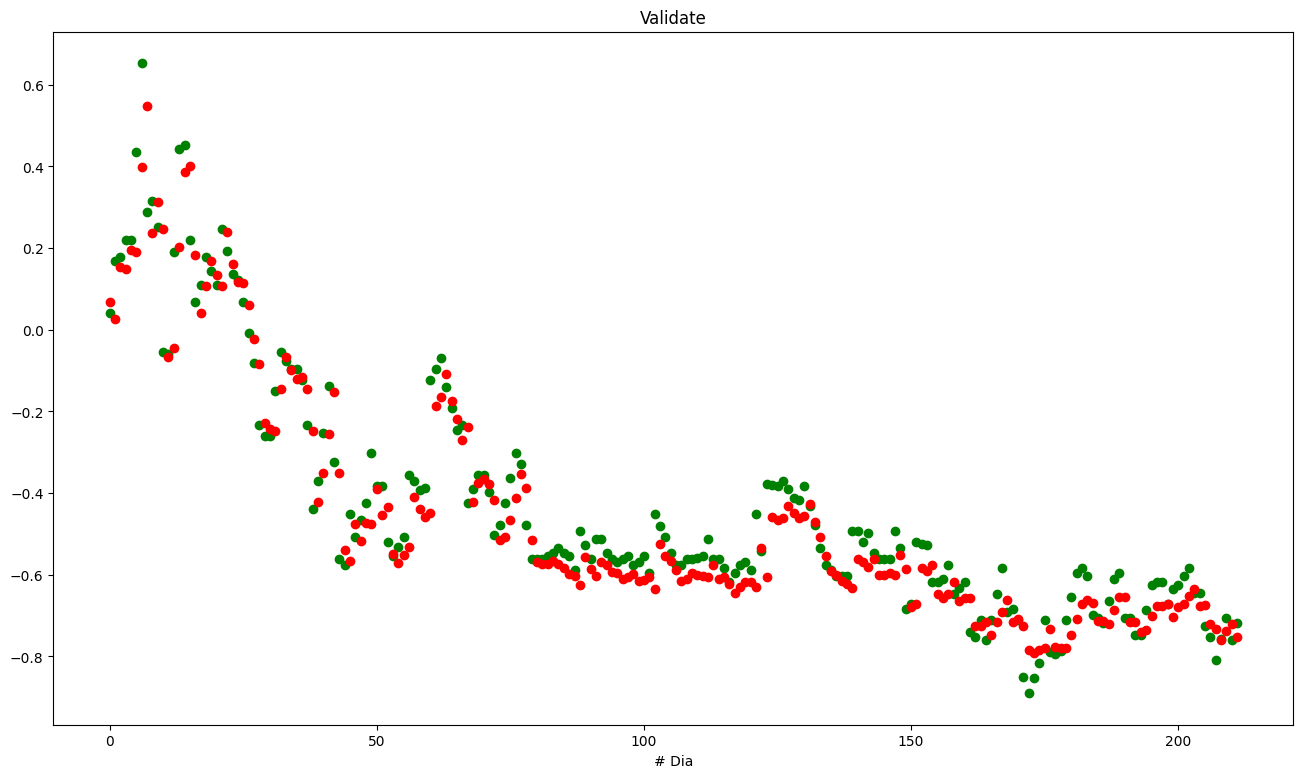

In [ ]:
results=model.predict(x_val)
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.xlabel("# Dia")
plt.title('Validate')
plt.show()


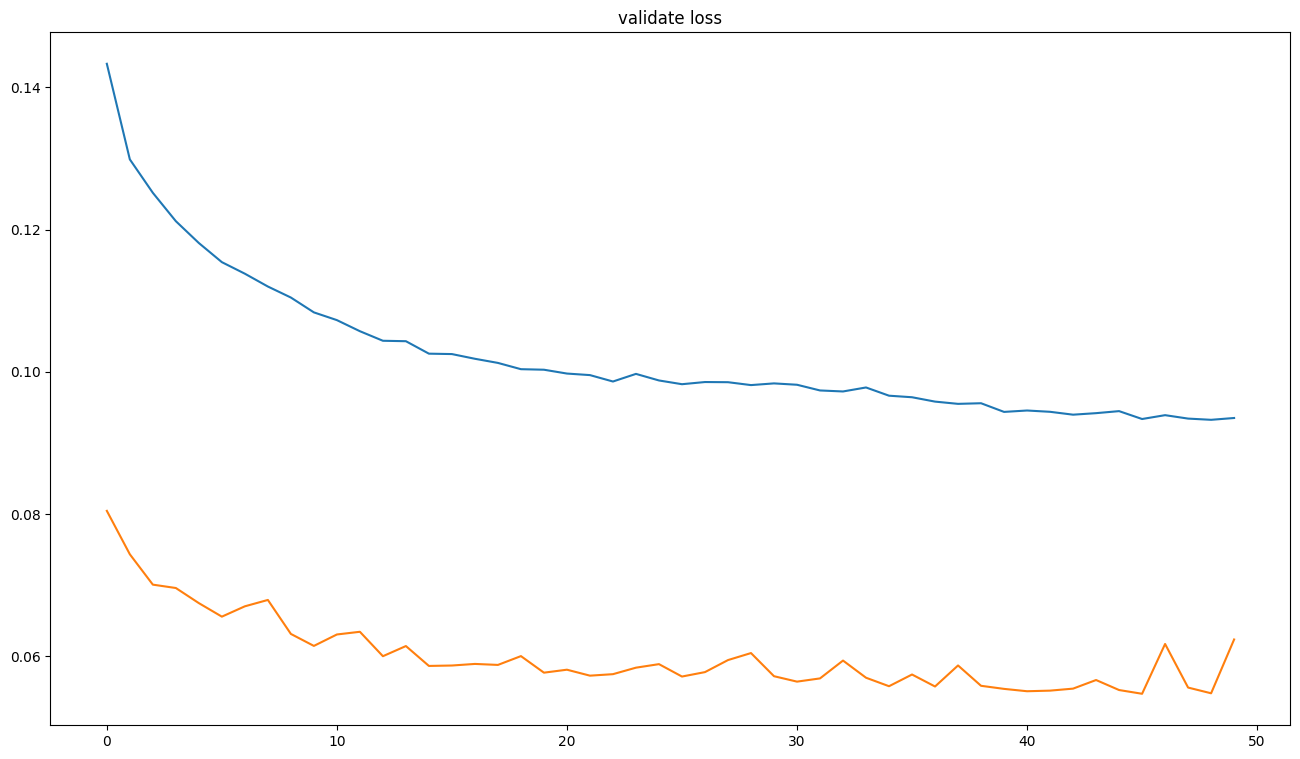

In [ ]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

## **Pronóstico del precio futuro**


A partir de las últimas 2 semanas de noviembre 2023
intentaremos predecir la primera semana de diciembre.

In [ ]:
ultimosDias = df['2021-11-16':'2021-11-30']
dias = len(ultimosDias)
print(dias)
ultimosDias


15


fecha
2021-11-16    1542.0
2021-11-17    1500.0
2021-11-18    1500.0
2021-11-19    1688.0
2021-11-20    1597.0
2021-11-21    1600.5
2021-11-22    1604.0
2021-11-23    1635.0
2021-11-24    1604.0
2021-11-25    1458.0
2021-11-26    1438.0
2021-11-27    1354.0
2021-11-28    1552.0
2021-11-29    1750.0
2021-11-30    1694.0
Name: unidades, dtype: float64

In [ ]:
values = ultimosDias.values
values = values.astype('float32')
# normalize features
values=values.reshape(-1, 1)
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[7]], axis=1, inplace=True)
reframed.head(7)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
7,-0.050505,-0.262626,-0.262626,0.686869,0.227273,0.244949,0.262627
8,-0.262626,-0.262626,0.686869,0.227273,0.244949,0.262627,0.419192
9,-0.262626,0.686869,0.227273,0.244949,0.262627,0.419192,0.262627
10,0.686869,0.227273,0.244949,0.262627,0.419192,0.262627,-0.474747
11,0.227273,0.244949,0.262627,0.419192,0.262627,-0.474747,-0.575758
12,0.244949,0.262627,0.419192,0.262627,-0.474747,-0.575758,-1.000000
13,0.262627,0.419192,0.262627,-0.474747,-0.575758,-1.000000,0.000000


In [ ]:
values = reframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
x_test

array([[[ 0.26262665,  0.4191923 ,  0.26262665, -0.47474718,
         -0.5757575 , -1.        ,  0.        ]],

       [[ 0.4191923 ,  0.26262665, -0.47474718, -0.5757575 ,
         -1.        ,  0.        ,  1.        ]]], dtype=float32)

In [ ]:
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

In [ ]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

1/1 [==============================] - 0s 24ms/step
[[[ 0.26262665  0.4191923   0.26262665 -0.47474718 -0.5757575
   -1.          0.        ]]

 [[ 0.4191923   0.26262665 -0.47474718 -0.5757575  -1.
    0.          1.        ]]]
1/1 [==============================] - 0s 22ms/step
[[[ 0.4191923   0.26262665 -0.47474718 -0.5757575  -1.
    0.          0.01230311]]

 [[ 0.4191923   0.26262665 -0.47474718 -0.5757575  -1.
    0.          1.        ]]]
1/1 [==============================] - 0s 21ms/step
[[[ 0.26262665 -0.47474718 -0.5757575  -1.          0.
    0.01230311  0.046917  ]]

 [[ 0.4191923   0.26262665 -0.47474718 -0.5757575  -1.
    0.          1.        ]]]
1/1 [==============================] - 0s 22ms/step
[[[-0.47474718 -0.5757575  -1.          0.          0.01230311
    0.046917    0.0286298 ]]

 [[ 0.4191923   0.26262665 -0.47474718 -0.5757575  -1.
    0.          1.        ]]]
1/1 [==============================] - 0s 21ms/step
[[[-0.5757575  -1.          0.          0.012

In [ ]:
adimen = [x for x in results]
inverted = scaler.inverse_transform(adimen)
inverted

array([[1554.43598484],
       [1561.28953482],
       [1557.66866875],
       [1550.62270123],
       [1543.99978241],
       [1531.28407412],
       [1529.44394852]])

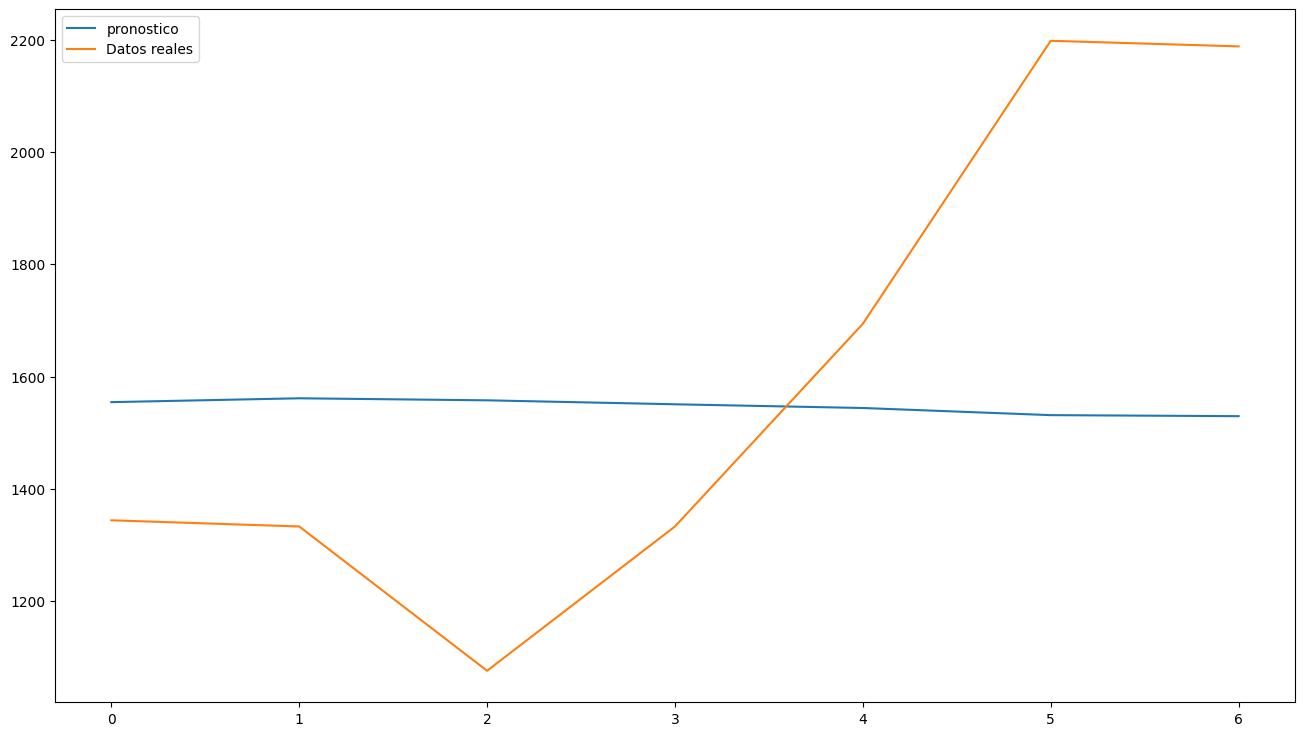

In [ ]:
prediccion1Semana = pd.DataFrame(inverted)
prediccion1Semana.columns = ['pronostico']
prediccion1Semana.plot()
prediccion1Semana.to_csv('pronostico.csv')
datosreales = df['2021-12-01':'2021-12-07']
plt.plot(datosreales.values, label ='Datos reales')
plt.legend()
plt.show()

En naranja los datos reales, en azul la prediccion, se observa que el comportamiento de la red es "timido" usando la informacion de 15 dias anteriores al rango a predecir, usa el modelo aprendido y muestra un comportamiento cercano a la media de los datos reales.